# Building Your First ML Pipeline
In this workshop we will work on a <strong>text classification</strong> task. The goal of text classification is to assign a label or a class to input text.

&nbsp;

 <<< *In case you are already familiar with the basics of text classification, you can skip the following intro and move on to __Dataset and model__ below it.* >>>
 
 &nbsp;


It is a very common task in <strong>Natural Language Processing (NLP)</strong> field and is quite straightforward to start with!


There are many uses cases for which text classification is used, some examples:

 
* Sentiment analysis and toxicity detection (review score prediction, comment section analysis)

* Topic classification (news article topic prediction, literature genre classification)


* Intent detection (user intent classification for Chatbots, search query intent)


* Spam detection, language identification etc.


Depending on a task, the classification can be either:
* Binary with only 2 classes

* Multi-class - multiple mutually exclusive classes

* Multi-label classification - not mutually exclusive, one entry can be assigned to none or to multiple labels

&nbsp;

 <<< *End of skippable info section.* >>>
 
 &nbsp;

## Dataset and model
We will be working on an <strong>intent detection</strong> task. 

Our dataset is called  [<strong>Banking77</strong>](https://huggingface.co/datasets/PolyAI/banking77), it contains online banking queries annotated with their corresponding intents. All queries are in English.
Overall, in this dataset there are 13,083 customer service queries labeled with 77 intents.

<strong>Our goal:</strong> build a model which can predict the intent for a previously unseen user query. Each query needs to be assigned to a single intent which makes this problem a multi-class text classification.


Predicting the intent of a user query is useful because it can make it possible to automate commonly needed functionality, save customers time and improve service satisfaction and ease load on customer support.

# What we will do:
* First, we will load the data and explore it


* Then, we will convert our texts to their vector representation to prepare the data for model training 


* We will try out 2 simple models and select the best parameters to use for them


* In the end, we will create a simple online API with Streamlit and test our solution live!

## Let's get started!

First, let's import what we will be using today. The needed libraries are:
* [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html) - very commonly used tabular data analysis and manipulation tool
* [numpy](https://numpy.org/doc/stable/) -  also a very commonly used package for scientific computing in Python
* [scikit-learn](https://scikit-learn.org/stable/) - another library which is commonly used in data science and contains lots of tools for machine learning and statistical modeling 
* [sentence_transformers](https://sbert.net/) -  a library for accessing, using, and training embedding models, part of the Hugging Face ecosystem. We will use it to access one of the embeddings models to vectorize our texts.
* [datasets](https://huggingface.co/docs/datasets/en/index) - a library for easily accessing and sharing datasets, part of the Hugging Face ecosystem. We will only be using it to access the Banking77 dataset.
* [mlflow](https://mlflow.org/docs/latest/index.html) - an open-source platform for machine learning developments, most often used for model, artifact, parameter logging and sharing, experiment (model runs) comparison. 

They are already being defined and installed in the requirements.txt file.


In [78]:
import pandas as pd
import numpy as np
from datasets import load_dataset

import mlflow

from sentence_transformers import SentenceTransformer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

# Exploring the data

Loading the [dataset](https://huggingface.co/datasets/PolyAI/banking77):

In [79]:
dataset = load_dataset("PolyAI/banking77", revision="main") # taking the data from the main branch

Our data is split in training and testing sets. Both have 2 columns: text and label. Training data contains 10,003 rows and test data contains 3,080 rows. 

In [80]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3080
    })
})

You can read more about how to work with the datasets library [here](https://huggingface.co/docs/datasets/en/quickstart), but we won't need anything other than the function above for this workshop.

Let's convert the datasets to pandas library DataFrame format: 

In [81]:
train_data = pd.DataFrame(dataset['train'])
test_data = pd.DataFrame(dataset['test'])

Pandas makes working with data and doing simple data analysis very convenient. Below we will use some of the pandas functions like [head](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html), [value_counts](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html), [describe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html), [plot](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html) for analysis.

First, let's look at the top rows of the dataset:

In [82]:
train_data.head()

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11


Our labels are numerical as you can see. These are positional indexes from the list of intent names (below) for this dataset. Let's add the labels names to make the data more interpretable. This will be useful since these labels are the intent which we want to predict.

In [83]:
label_names = [
    "activate_my_card",
    "age_limit",
    "apple_pay_or_google_pay",
    "atm_support",
    "automatic_top_up",
    "balance_not_updated_after_bank_transfer",
    "balance_not_updated_after_cheque_or_cash_deposit",
    "beneficiary_not_allowed",
    "cancel_transfer",
    "card_about_to_expire",
    "card_acceptance",
    "card_arrival",
    "card_delivery_estimate",
    "card_linking",
    "card_not_working",
    "card_payment_fee_charged",
    "card_payment_not_recognised",
    "card_payment_wrong_exchange_rate",
    "card_swallowed",
    "cash_withdrawal_charge",
    "cash_withdrawal_not_recognised",
    "change_pin",
    "compromised_card",
    "contactless_not_working",
    "country_support",
    "declined_card_payment",
    "declined_cash_withdrawal",
    "declined_transfer",
    "direct_debit_payment_not_recognised",
    "disposable_card_limits",
    "edit_personal_details",
    "exchange_charge",
    "exchange_rate",
    "exchange_via_app",
    "extra_charge_on_statement",
    "failed_transfer",
    "fiat_currency_support",
    "get_disposable_virtual_card",
    "get_physical_card",
    "getting_spare_card",
    "getting_virtual_card",
    "lost_or_stolen_card",
    "lost_or_stolen_phone",
    "order_physical_card",
    "passcode_forgotten",
    "pending_card_payment",
    "pending_cash_withdrawal",
    "pending_top_up",
    "pending_transfer",
    "pin_blocked",
    "receiving_money",
    "Refund_not_showing_up",
    "request_refund",
    "reverted_card_payment?",
    "supported_cards_and_currencies",
    "terminate_account",
    "top_up_by_bank_transfer_charge",
    "top_up_by_card_charge",
    "top_up_by_cash_or_cheque",
    "top_up_failed",
    "top_up_limits",
    "top_up_reverted",
    "topping_up_by_card",
    "transaction_charged_twice",
    "transfer_fee_charged",
    "transfer_into_account",
    "transfer_not_received_by_recipient",
    "transfer_timing",
    "unable_to_verify_identity",
    "verify_my_identity",
    "verify_source_of_funds",
    "verify_top_up",
    "virtual_card_not_working",
    "visa_or_mastercard",
    "why_verify_identity",
    "wrong_amount_of_cash_received",
    "wrong_exchange_rate_for_cash_withdrawal",
]

In [84]:
# assign label names from the list based on the index of the label 
train_data["virtual_card_not_working"] = train_data["label"].apply(lambda x: label_names[x])
test_data["virtual_card_not_working"] = test_data["label"].apply(lambda x: label_names[x])

Let's look at the top rows again. Now we have the label name as well:

In [85]:
train_data.head()

,text,label,virtual_card_not_working
0,I am still waiting on my card?,11,card_arrival
1,What can I do if my card still hasn't arrived ...,11,card_arrival
2,I have been waiting over a week. Is the card s...,11,card_arrival
3,Can I track my card while it is in the process...,11,card_arrival
4,"How do I know if I will get my card, or if it ...",11,card_arrival


Let's check the shape (# of row and columns of the data)

In [86]:
print(
f"""
      Train dataset shape: {train_data.shape}, 
      Test dataset shape: {test_data.shape}
"""
)


      Train dataset shape: (10003, 3), 
      Test dataset shape: (3080, 3)



Take a look at a random sample of 20 rows:

In [87]:
train_data.sample(20)

,text,label,virtual_card_not_working
3252,Why did my money disappear when I topped up??,61,top_up_reverted
5525,i haven't received my order and want a refund,52,request_refund
1724,I put the wrong pin too many times and now it ...,49,pin_blocked
52,What can I do to track the card you sent me?,11,card_arrival
5411,My package is taking too long to arrive and I ...,52,request_refund
7709,Please help me find my top-up verification code,71,verify_top_up
1426,How do I exchange currencies with this,33,exchange_via_app
5793,Can you let me know where my refund money is? ...,51,Refund_not_showing_up
8188,My virtual car is not working.,72,virtual_card_not_working
6972,How can I change my old pin to a new one?,21,change_pin




To check the sample counts for the labels we have. We can use the pandas [value_counts](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) function for this.


Looks like intent with the most labeled examples in the training data has 187 samples and is called "card_payment_fee_charged". The intent with the least amount of examples has 35 samples and is called "contactless_not_working".


In [88]:
train_data["virtual_card_not_working"].value_counts()

virtual_card_not_working
card_payment_fee_charged                            187
direct_debit_payment_not_recognised                 182
balance_not_updated_after_cheque_or_cash_deposit    181
wrong_amount_of_cash_received                       180
cash_withdrawal_charge                              177
                                                   ... 
lost_or_stolen_card                                  82
card_swallowed                                       61
card_acceptance                                      59
virtual_card_not_working                             41
contactless_not_working                              35
Name: count, Length: 77, dtype: int64

Let's check the statistics on the count of labeled examples per intent with the [describe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) function below.


* We have 77 unique intents
* Mean number of examples per intent is 129, with standard deviation of 32
* The minimum is 35 examples and the maximum is 187
* The 25th percentile is 112 examples, median is 127, 75th percentile is 159


Seems like we have some deviations with less labeled intents, but overall the labels are relatively balanced.

In [89]:
train_data["virtual_card_not_working"].value_counts().describe()

count     77.000000
mean     129.909091
std       32.942207
min       35.000000
25%      112.000000
50%      127.000000
75%      159.000000
max      187.000000
Name: count, dtype: float64

We can see the same distribution by using the *plot* function to create the bar plot of the sample count per label:

<Axes: title={'center': 'Label Distribution'}, ylabel='virtual_card_not_working'>

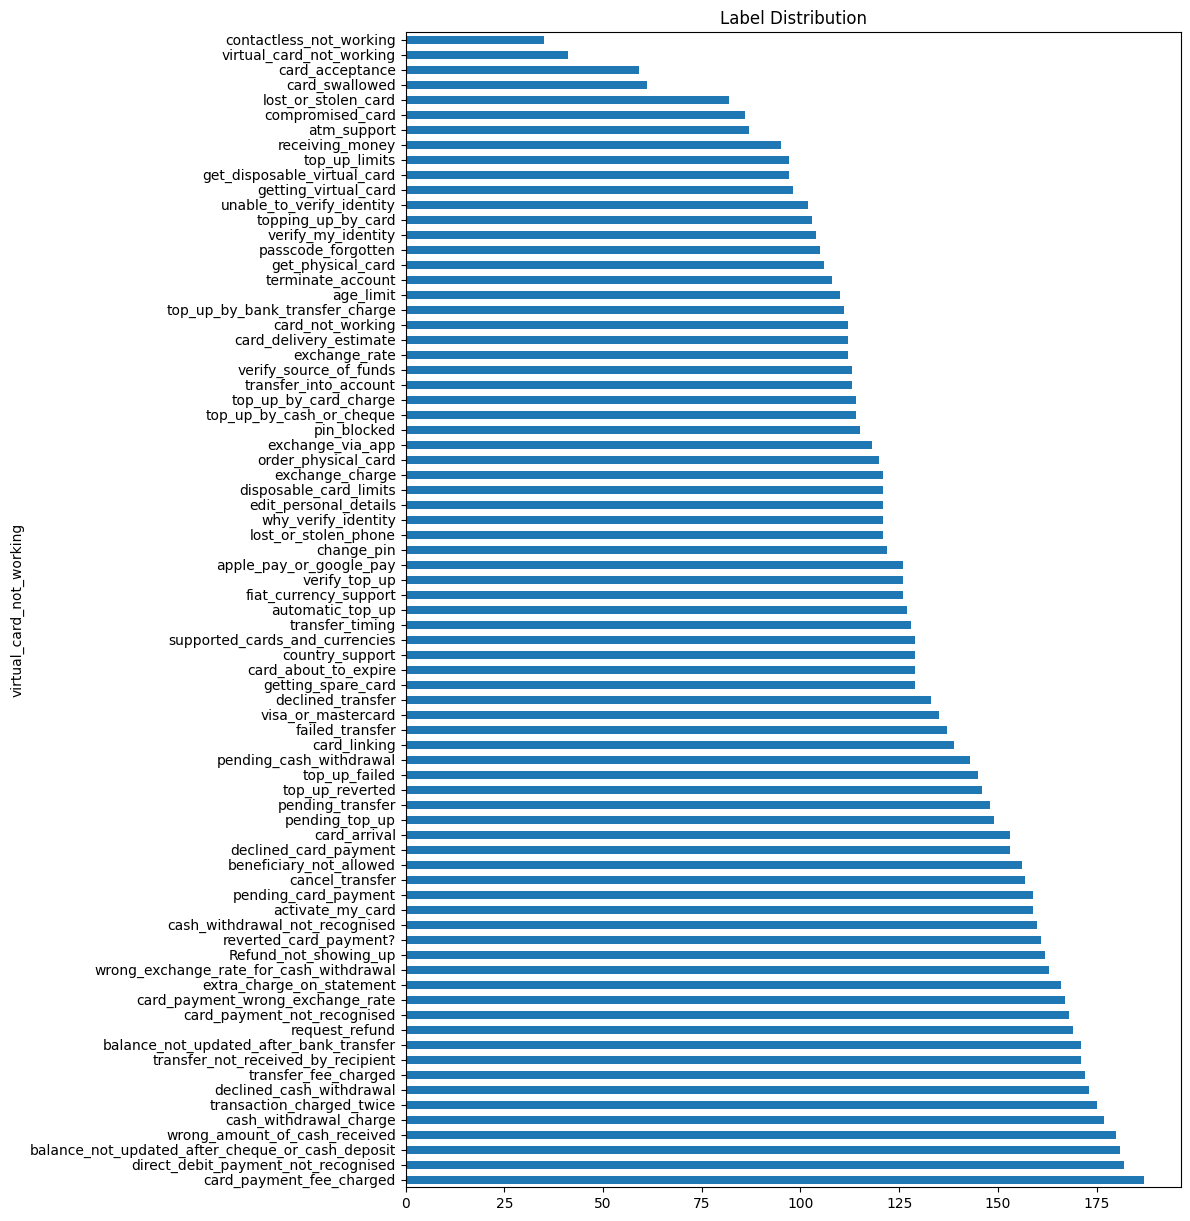

In [90]:
train_data["virtual_card_not_working"].value_counts().plot.barh(title='Label Distribution', figsize=(10,15))

Let's check the lengths of the user query texts and the number of tokens (roughly words) per query: 

In [91]:
train_data['text_length'] = train_data['text'].str.len()  # get the text length (https://pandas.pydata.org/docs/reference/api/pandas.Series.str.len.html)
train_data['text_num_tokens'] = train_data['text'].str.split().str.len()  # split the text by spaces and get the length of the resulting list to calculate the number of tokens (https://pandas.pydata.org/docs/reference/api/pandas.Series.str.split.html)

Example of how we can get the length of the text and the number of tokens:

In [92]:
text = "Here is a text"
tokens = text.split()

print(f"Length of the text is: {len(text)}")
print(f"Tokens of the text are: {tokens}")
print(f"The number of tokens is: {len(tokens)}")

Length of the text is: 14
Tokens of the text are: ['Here', 'is', 'a', 'text']
The number of tokens is: 4


We can use the [describe function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) from pandas to take a look at the statistics for user query text length:

In [93]:
train_data['text_length'].describe()


count    10003.000000
mean        59.473758
std         40.867901
min         13.000000
25%         36.000000
50%         47.000000
75%         64.000000
max        433.000000
Name: text_length, dtype: float64

## Task 1
Calculate the statistics for the number of tokens in user queries using the pandas [describe function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html). In addition to the default values, include the 10th and 90th percentiles.

In [94]:
### YOUR CODE HERE ###
train_data['text_num_tokens'].describe(percentiles=[0.1, 0.9], include=all, exclude=None)

count    10003.000000
mean        11.949415
std          7.891577
min          2.000000
10%          6.000000
50%         10.000000
90%         22.000000
max         79.000000
Name: text_num_tokens, dtype: float64

Once you have completed the previous step, let's plot the histograms of the distributions:

<Axes: title={'center': 'Text Length'}, ylabel='Frequency'>

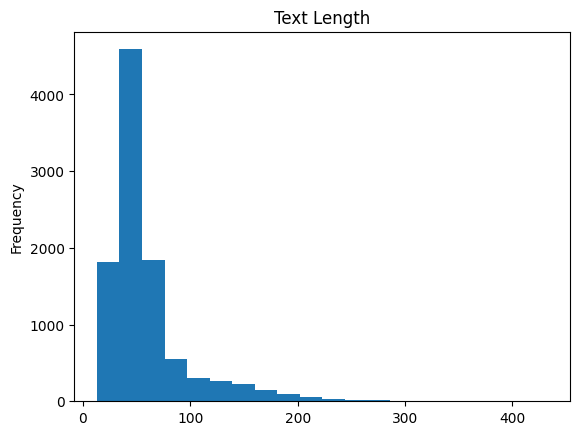

In [95]:
train_data['text_length'].plot.hist(title='Text Length', bins=20)

In [96]:
train_data['text_num_tokens']

0         7
1        13
2        12
3        13
4        15
         ..
9998      6
9999      5
10000     5
10001     6
10002     4
Name: text_num_tokens, Length: 10003, dtype: int64

<Axes: title={'center': 'Number of tokens'}, ylabel='Frequency'>

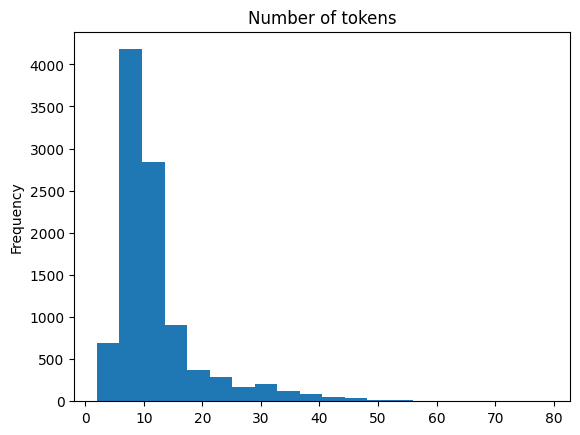

In [97]:
train_data['text_num_tokens'].plot.hist(title='Number of tokens', bins=20)

We can also take a lot of these distributions by label name to see if there are any significant differences. We can use the [groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) function of pandas to calculate the statistics with the *describe* function per label:

In [98]:
# Text length
text_length_statistics = train_data.groupby('virtual_card_not_working')['text_length'].describe()
text_length_statistics

,count,mean,std,min,25%,50%,75%,max
virtual_card_not_working,,,,,,,,
Refund_not_showing_up,162.0,77.919753,62.354923,16.0,37.0,47.5,91.50,241.0
activate_my_card,159.0,43.528302,16.728211,16.0,31.5,41.0,50.00,117.0
age_limit,110.0,43.163636,12.887322,22.0,34.0,41.0,49.75,83.0
apple_pay_or_google_pay,126.0,47.158730,17.799062,24.0,35.0,41.0,52.00,113.0
atm_support,87.0,36.873563,9.073094,16.0,31.0,35.0,43.00,72.0
...,...,...,...,...,...,...,...,...
virtual_card_not_working,41.0,49.365854,22.150345,28.0,37.0,44.0,53.00,123.0
visa_or_mastercard,135.0,39.274074,12.117232,18.0,31.0,37.0,46.00,78.0
why_verify_identity,121.0,49.404959,16.423854,22.0,38.0,45.0,59.00,93.0


### Task 2

Now calculate these statistics for the number of tokens columns, also using groupby by label name. Find which label has the highest mean number of tokens?

In [99]:
### YOUR CODE HERE ###
text_num_tokens_statistics = train_data.groupby('virtual_card_not_working')['text_num_tokens'].describe()
text_num_tokens_statistics

,count,mean,std,min,25%,50%,75%,max
virtual_card_not_working,,,,,,,,
Refund_not_showing_up,162.0,15.808642,12.293782,4.0,8.0,10.0,20.0,50.0
activate_my_card,159.0,9.150943,3.349265,3.0,7.0,9.0,11.0,20.0
age_limit,110.0,9.236364,2.785702,4.0,7.0,9.0,11.0,17.0
apple_pay_or_google_pay,126.0,10.341270,3.575836,5.0,8.0,9.0,12.0,23.0
atm_support,87.0,7.689655,2.001804,4.0,6.0,8.0,9.0,13.0
...,...,...,...,...,...,...,...,...
virtual_card_not_working,41.0,9.365854,4.575785,5.0,6.0,8.0,10.0,25.0
visa_or_mastercard,135.0,8.155556,2.617013,3.0,7.0,8.0,9.0,16.0
why_verify_identity,121.0,9.322314,3.165478,4.0,7.0,9.0,11.0,19.0


Let's visualize the mean values for user query text length and token count per label:

<Axes: title={'center': 'Mean Text Length'}, ylabel='virtual_card_not_working'>

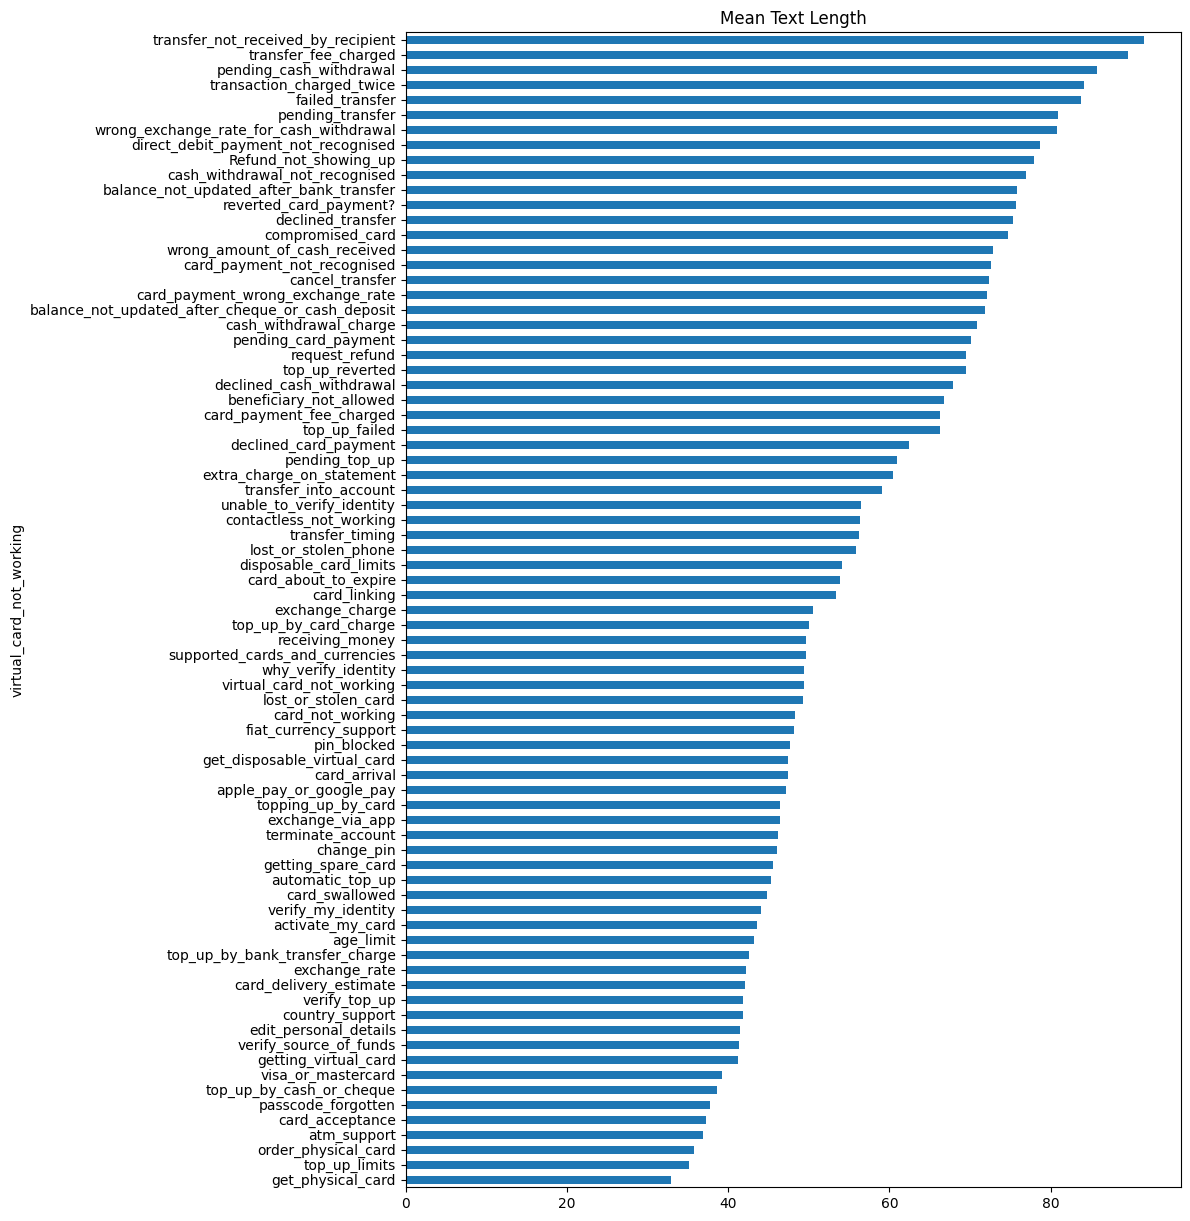

In [100]:
text_length_statistics.sort_values(by='mean')['mean'].plot.barh(title='Mean Text Length', figsize=(10,15))

## Task 3
Create a graph for the number of tokens per label like is done above for text lengths, but pick a different statistic other than the mean. Make sure the graph is sorted from highest to lowest value as well.

<Axes: title={'center': 'Max token'}, ylabel='virtual_card_not_working'>

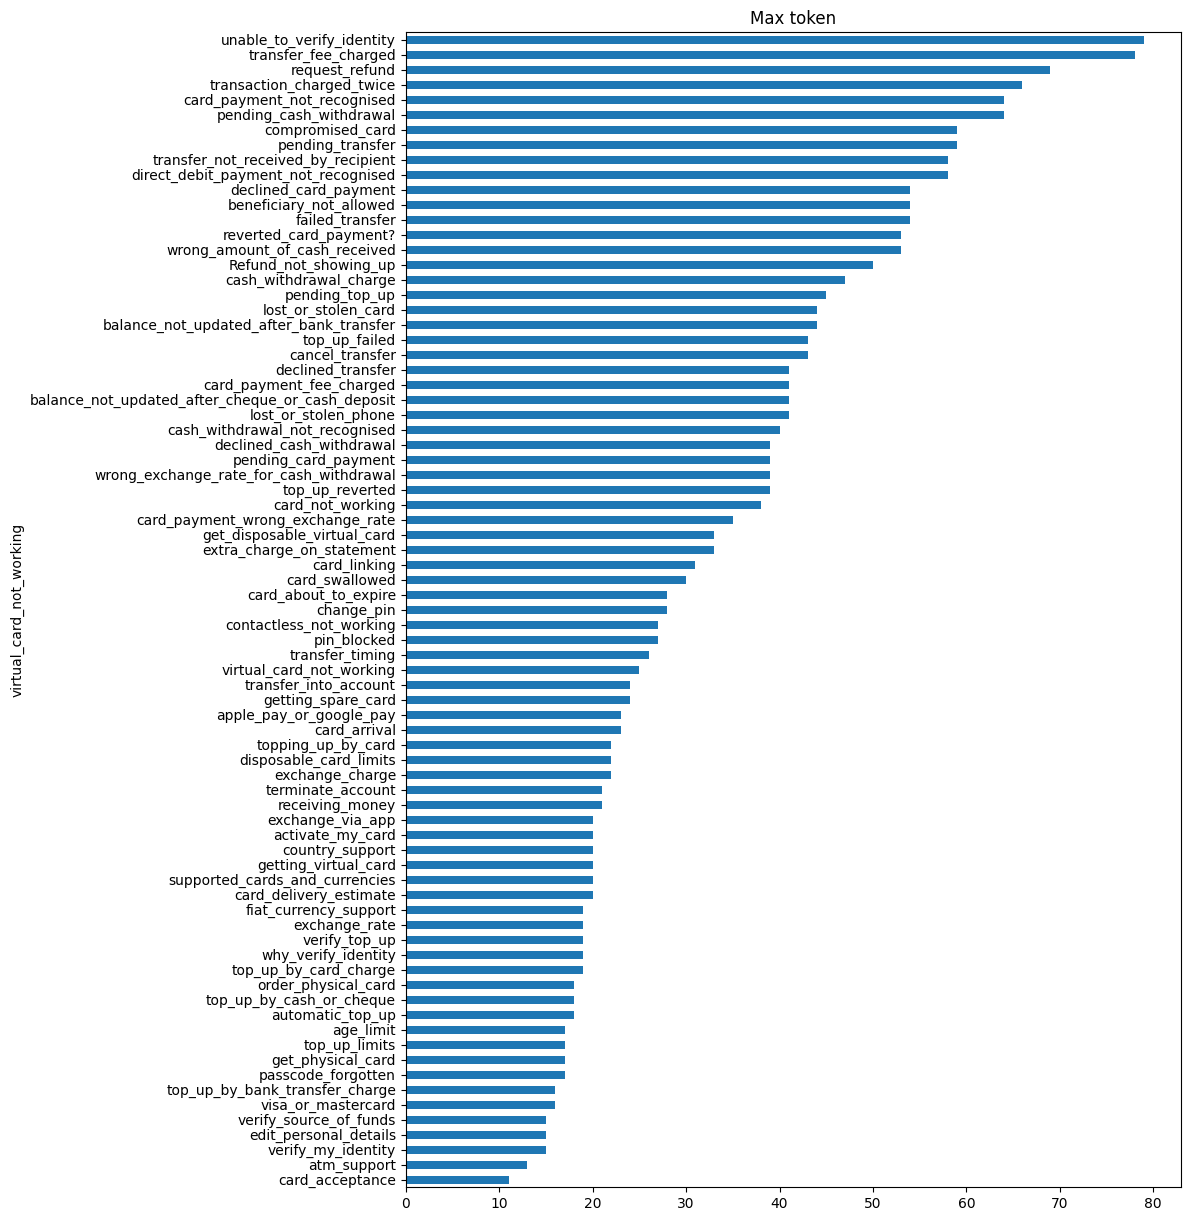

In [101]:
### YOUR CODE HERE ###
text_num_tokens_statistics.sort_values(by='max')['max'].plot.barh(title='Max token value', figsize=(10,15))

Looks like there are some differences between labels in terms of text length and token number. This can mean that they would be useful features for modeling.

## Text Embeddings

&nbsp;

 <<< *In case you are already familiair with the concept of text embeddings, you can skip the following intro.* >>>
 
 &nbsp;

To be able to train our model we need to convert our training data in the form of text into numerical representations. We also need to do the same for our test data to be able to make predictions. This conversion from text into numerical representations is also called vectorization.


There are several ways to vectorize text data, one of them which is often used is text embeddings. Text embeddings are vectors (lists) or floating point numbers and they are designed to capture the semantic meaning and context of the words they represent. There are many models available which can be used for getting embeddings from given text. Some examples, from simple to closer to state-of-the-art, are:
* [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html)
* [FastText](https://fasttext.cc/docs/en/crawl-vectors.html)
* [Universal sentence encoder (USE)](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder.ipynb)
* [BERT](https://huggingface.co/docs/transformers/en/model_doc/bert)
* [DistilBERT](https://huggingface.co/docs/transformers/en/model_doc/distilbert)
* [XLNet](https://huggingface.co/docs/transformers/en/model_doc/xlnet)
* [MPNet](https://huggingface.co/docs/transformers/en/model_doc/mpnet)
* [GPT](https://platform.openai.com/docs/guides/embeddings)




You can check more available models on, for example but not limited to, [sentence_transformers](https://sbert.net/docs/sentence_transformer/pretrained_models.html) and Hugging Face [model hub](https://huggingface.co/models?pipeline_tag=sentence-similarity&sort=downloads) (sentence similarity models linked), there are also others. 


Embeddings are useful in multiple kinds of tasks:
* Text similarity measurement
* Text classification
* Semantic search
* Text clusterization
* Recommendations


and others.


Embeddings can also be limited to a single language or be multilingual and support a varying number of languages.

&nbsp;

 <<< *End of skippable intro on text embeddings* >>>
 
 &nbsp;

For building our model, we will make use of the idea that very similar sentences likely belong to the same intent label.
For our embeddings, we will take an MPNet English language model developed by Microsoft and called [all-mpnet-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2). It was trained for sentence similarity tasks and therefore produces embeddings which work well for our needs. 

Example of how the embeddings can be accessed, we need to load the model with needed path and use the *encode* function. See [here](https://huggingface.co/sentence-transformers/all-mpnet-base-v2):

In [102]:
sentences = ["This is an example sentence", "Each sentence is converted"]

embeddings_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embeddings = embeddings_model.encode(sentences)
print(embeddings)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/home/codespace/.python/current/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[[ 0.0225026  -0.0782918  -0.02303072 ... -0.00827929  0.0265269
  -0.00201896]
 [ 0.04170237  0.00109739 -0.01553418 ... -0.02181626 -0.06359357
  -0.00875284]]


Let's check on one of the queries from our data:

In [103]:
embeddings_model.encode('I am still waiting on my card?')

array([ 3.31176147e-02,  2.42412109e-02, -2.71984357e-02,  1.26691274e-02,
       -2.76750308e-02,  1.82584077e-02,  1.66267855e-04,  1.86158884e-02,
       -2.01713219e-02, -1.54021382e-02,  1.20541789e-01,  2.84008682e-02,
        3.07077263e-02,  2.06049867e-02, -8.39670002e-02,  5.41590303e-02,
        8.79565626e-03, -1.77969132e-03,  3.90263945e-02,  1.31505635e-02,
       -1.63296647e-02,  3.82990502e-02, -2.46205013e-02, -2.83711292e-02,
       -6.90191016e-02,  3.21710072e-02,  2.33253874e-02, -7.32264221e-02,
       -7.74020515e-03, -5.14665432e-02,  3.37348729e-02,  1.17909983e-02,
       -1.73852965e-02,  1.11291306e-02,  1.27088754e-06, -2.41051558e-02,
        6.86141625e-02,  3.64308283e-02, -4.29290645e-02,  7.08928984e-03,
        1.14820879e-02, -6.29544929e-02, -3.00135985e-02, -9.77488980e-03,
       -3.32831778e-02, -3.45285982e-02,  4.79110982e-03,  3.17018442e-02,
       -3.22451182e-02, -6.29704148e-02, -5.76855652e-02, -6.49791956e-02,
        9.23778210e-03,  

In [104]:
# Let's check the dimentions of the produced vector
embeddings_model.encode('I am still waiting on my card?').shape

(768,)

## Task 4
Semantic similarity between texts is often measured with cosine similarity. Mathematically, it's the cosine of the angle between 2 vectors, meaning the dot product of the vectors divided by the product of their lengths. When we want to calculate the cosine similarity of 2 texts, text embeddings can be used as the vector representation.


Your task is to <strong>calculate the cosine similarity of 2 given texts</strong> using the all-mpnet-base-v2 embeddings model we downloaded above. You can implement the cosine similarity function yourself using numpy (or look up how to implement it in Python).
 
Feel free to try out any of your own text examples!

In [108]:

from numpy import dot
from numpy.linalg import norm

text_1 = "When will my card be delivered?"	
text_2 = "How long will my card delivery take?"

### YOUR CODE HERE ###
a = embeddings_model.encode(text_1)
b = embeddings_model.encode(text_2)

cos_sim = dot(a, b)/(norm(a)*norm(b))
print(cos_sim)

0.88881814


Once we are done with task 4, let's proceed to training our model! But first we need to vectorize our train and test datasets using the embeddings model.

## Preparing the data

To be able to train and test our model we need to convert all our user queries in the training and test datasets into embeddings.

We can do so by putting all of the queries of respective datasets into lists with a *tolist* function and then applying the embedding model the same way as in the examples above. This will create 2 embedding matrices which are ready for model training and inference.

In [109]:
train_text_lists = train_data["text"].tolist()
test_text_lists = test_data["text"].tolist()

In [110]:
# command takes around 4-5 mins to run
train_embeddings = embeddings_model.encode(train_text_lists, show_progress_bar=True)
test_embeddings = embeddings_model.encode(test_text_lists, show_progress_bar=True)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/97 [00:00<?, ?it/s]

# Modeling

### Algorithms

&nbsp;

 <<< *In case you are already familiair with the basics of k-NN and/or Logistic Regression, you can skip the following two info sections and move on to the __K-nearest Neighbors__ section below them.* >>>
 
 &nbsp;

We will train 2 simple models based on [K-nearest Neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) and [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression) algorithms.

<strong>k-Nearest Neighbors (k-NN) Classification</strong>
k-NN classification works by memorizing all the training examples and then classifying a new data point based on its proximity to these memorized examples. For prediction, the algorithm calculates the distance between the new data point and examples in the training set. It then identifies the k closest training examples, i.e. neighbors, and assigns to the new data point the class that is most common among these k neighbors. All neighbors can either count equally to the predicted class vote or the closer neighbors can have more weight. The final predictions are scores representing the class vote distribution.

<strong>Logistic Regression</strong>
Logistic regression operates by first computing a linear combination of the input features. The result is then passed through the logistic (sigmoid) function, which maps it to a probability between 0 and 1. This probability represents the likelihood of the data point belonging to the positive class. If the probability is above a certain threshold (typically 0.5 but this can be tuned depending on the needs) the data point is classified as belonging to the positive class. Otherwise, it is classified as belonging to the negative class. Logistic regression can also be extended to multi-class classification.

&nbsp;

 <<< *End of skippable info sections.* >>>
 
 &nbsp;

## K-nearest Neighbors

Let's start by fitting a K-nearest Neighbors model on the training data.
We will use scikit-learn implementation: [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier).

Although there are a lot of details, the scikit-learn API is fairly simple to use in practice: each estimator has a `.fit(X, y)` method to train a model and a `.predict(X)` method to predict on unseen data.

We will start by fitting the model with its default parameters and this will give us a baseline model, upon which we can improve.

In [111]:
# Initialize KNeighborsClassifier and fit on training data
model_baseline = KNeighborsClassifier()
model_baseline.fit(train_embeddings, train_data['virtual_card_not_working'])

KNeighborsClassifier()

In [113]:
# Let's check the results on cross-validation (more on how cross-validation works in Model Evaluation section)
cv_scores = cross_val_score(estimator=model_baseline, X=train_embeddings, y=train_data['virtual_card_not_working'], scoring="f1_macro", cv=3)

print(
    f"""
      Baseline model CV scores by fold: {cv_scores}, 
      Mean CV score {cv_scores.mean()}
"""
)



      Baseline model CV scores by fold: [0.91624116 0.91954865 0.90722442], 
      Mean CV score 0.9143380775893112



# Hyperparameters Tunning

The process of finding the optimal hyperparameters for your task is called [hyperparameter tuning](https://scikit-learn.org/stable/modules/grid_search.html). It involves experimenting with different hyperparameter values of an algorithm to find the combination that yields the best model performance on a validation set. This can be done using techniques like [grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV), where all possible combinations are tried, or random search, where random combinations are tested.

To tune hyperparameters for our models we will use [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). It optimizes hyperparameters by randomly sampling a specified number of combinations from a given range. Each combination is evaluated using [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html), and the best performing set is selected. This method is more efficient than exhaustive searches, as it explores the hyperparameter space more quickly while still finding effective parameter settings.

### K-nearest Neighbors Hyperparameter tuning

Below we define values for our hyperparameter choices, refer to the scikit-learn documentation for more details on [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) settings.

We are using the F1-score metric since it is well suited for our task - customer support text classification. For this case, it's important to balance precision and recall which [F1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score) helps to achieve. "Macro" in F1-macro is an averaging strategy, it means that the metrics are calculated for each label separately, and then their unweighted mean is found for the final score.

In [115]:
params = {
    "n_neighbors": [3, 5, 7, 9, 11, 13, 15], # number of neighbors
    "weights": ["distance", "uniform"], # whether the votes from all neighbors should be counted equally or by distance to the prediction point
    "metric": ["cosine", "euclidean" ], # which metric to use for distance calculation
}

# define RandomizedSearchCV
clf = RandomizedSearchCV(
    estimator=KNeighborsClassifier(n_jobs=-1),
    param_distributions=params,
    n_iter=20,
    random_state=0,
    cv=3,
    scoring="f1_macro",
)

In [116]:
# Run the hyperparameter tunining given the train data (train_embeddings) and target values (train_data['label_name']), command takes around 40s to run
search = clf.fit(train_embeddings, train_data['virtual_card_not_working']) 

Take a look at the best hyperparameters found and the achieved F1-score on cross-validation:

In [117]:
print(f"""
      Best parameters: {search.best_params_}
      F1-score: {search.best_score_}
""")


      Best parameters: {'weights': 'distance', 'n_neighbors': 5, 'metric': 'cosine'}
      F1-score: 0.9192700185828757



In [119]:
# Let's check the cross-validation score by fold for the model with tuned hyperparameters:

best_model = search.best_estimator_
cv_scores_tuned = cross_val_score(estimator=best_model, X=train_embeddings, y=train_data['virtual_card_not_working'], scoring="f1_macro", cv=3)

print(
    f"""
      Best model CV scores by fold: {cv_scores_tuned}, 
      Mean CV scores: {cv_scores_tuned.mean()} # same as above for search.best_score_
"""
)


      Best model CV scores by fold: [0.91962215 0.92372951 0.9144584 ], 
      Mean CV scores: 0.9192700185828757 # same as above for search.best_score_



We can see that, although very slightly, the f1_score on cross validation has increased after tuning hyperparameters. Depending on the task and data this difference can be more dramatic so tuning hyperparameters is worth the effort.

## Task 5

Tune hyperparameters for a Logistic regression model via RandomizedSearchCV like in the example above. Consider the following hyperparameters: `C`, `penalty` and `solver`, but you can also add any other ones you want to tune! Refer to [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression) documentation for hyperparameter choices.

<strong>Hint:</strong> for the values of C you can define a disrtibution of values to check with [numpy](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html) like this: `np.linspace(start=0.001, stop=10, num=21)`

In [ ]:

distributions = {
    'C': [1, 10, 50] 
    'penalty': {l1}
    'solver': 'lbfgs'
      ‘lbfgs’
}

# Hint: use a higher number of iterations (n_iter=100) for RandomizedSearchCV since more combinations would be possible here than in k-NN example
log_clf = ### YOUR CODE HERE ###

params = {
    "n_neighbors": [3, 5, 7, 9, 11, 13, 15], # number of neighbors
    "weights": ["distance", "uniform"], # whether the votes from all neighbors should be counted equally or by distance to the prediction point
    "metric": ["cosine", "euclidean" ], # which metric to use for distance calculation
}

# define RandomizedSearchCV
clf = RandomizedSearchCV(
    estimator=LogisticRegression(n_jobs=-1),
    param_distributions=params,
    n_iter=20,
    random_state=0,
    cv=3,
    scoring="f1_macro",
)

In [144]:
distributions = {
    'C': [10],
    'penalty': ['l2'], 
    'solver': ['newton-cg'],
}

# Hint: use a higher number of iterations (n_iter=100) for RandomizedSearchCV since more combinations would be possible here than in k-NN example
log_clf = RandomizedSearchCV(
    estimator=LogisticRegression(n_jobs=-1),
    param_distributions=distributions,
    n_iter=1,
    random_state=0,
    cv=3,
    scoring="f1_macro",
)

In [145]:
log_search = log_clf.fit(train_embeddings, train_data['virtual_card_not_working']) 

In [147]:
print(f"""
      Best parameters: {log_search.best_params_}
      F1-score: {log_search.best_score_}
""")


      Best parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 10}
      F1-score: 0.9258282832445485



# Model Evaluation

&nbsp;

 <<< *In case you are already familiair with the different components of model evaluation and cross-validation, feel free to skip the next info section.*>>>
 
 &nbsp;
 
### Components of [Model Evaluation](https://scikit-learn.org/stable/model_selection.html):

* [**Metric choice**](https://scikit-learn.org/stable/modules/model_evaluation.html): consider what is suitable for your task and model, as well as, what best reflects the requirements for the solution.
  * For example, in a customer support chatbot, we might care about [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) equally and therefore F1 would be the optimal metric. Or it might be that precision is more important since we would rather transfer the request to a human when the bot is unsure. Then we could use a weighted F1 where precision is weighed higher.
  * In some cases of binary classification, for example, it could be that we care about only the top N results with the highest prediction score, therefore we need to compute our metrics on this top set (it's called @k, for example, precision@k).
  * Also, in some cases of binary classification, it's important that your true positive examples get a higher predicted score, then [ROC AUC score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) is a suitable metric. In other cases, it might not be important and then accuracy, F1, precision, and recall could work better.
  * Don't use [accuracy score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) for imbalanced datasets since if your positive class is only 5% of the data, predicting all to be negative will give a 95% accuracy which seems high but is useless. Precision, recall, F1 would be better choices.  

* **Validation set evaluation**: This is also a possibility, especially for non-standard cases when cross-validation is challenging to apply. Be careful not to overfit the validation set! Note that the validation set is different from a test set in this case. The data is split into 3 parts - training, validation, and testing.

* **Test set evaluation**:
  * The test set should not be used during data preprocessing, model training, or hyperparameter tuning to prevent data leakage and biasing the evaluation results.
  * The purpose is to provide a final, unbiased evaluation of the model's performance.
  * Be careful to make sure that the test set is representative of the real production data and that the way it was split is suitable for your task. The same considerations as for cross-validation exist here; time series data or not independently and identically distributed data need to be treated differently.
  * Take note of the class imbalances in the test set compared to the production data. This can affect your metrics calculation reliability.
  * Final evaluation is always best in the production setting (such as in an A/B test), since only that can show the real performance and impact of the model

* [**Cross-validation**](https://scikit-learn.org/stable/modules/cross_validation.html):
  * Cross-validation works by splitting the training data into multiple subsets (folds). The model is trained on all of these subsets but one and is evaluated on this remaining one. This process is repeated several times (same as the number of folds), and the results are averaged.
  * It is often used for hyperparameter tuning and model selection. By using multiple folds, it generally provides a more robust estimate of the model's performance compared to a single train-test split.
  * Be careful with using cross-validation for time series data or data that is not independently and identically distributed (one row is not an independent entry, for example, the same user_id is present in the data multiple times). Use evaluation approaches suitable for your kind of task, such as [time series-aware validation splitting](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-of-time-series-data) or [Grouped cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html#group-cv).

 &nbsp;

 <<< *End of skippable info section.*>>>
 
 &nbsp;


Let's train our k-NN model with the hyperparameters which we found in the previous step with RandomizedSearchCV:

In [150]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='cosine')
knn.fit(train_embeddings,  train_data['virtual_card_not_working'])

KNeighborsClassifier(metric='cosine', weights='distance')

Getting the predictions on the test set to measure the final metrics:

In [151]:
prediction_knn = knn.predict(test_embeddings)

In our task of a customer support text classification, the metrics which are of interest to us are precision, recall and F1-score. We can use [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) function to calculate them for all classes separately and also get the overall results.

In [153]:
print(classification_report(test_data['virtual_card_not_working'], prediction_knn))

                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       1.00      1.00      1.00        40
                                activate_my_card       1.00      0.95      0.97        40
                                       age_limit       1.00      1.00      1.00        40
                         apple_pay_or_google_pay       1.00      1.00      1.00        40
                                     atm_support       1.00      1.00      1.00        40
                                automatic_top_up       1.00      1.00      1.00        40
         balance_not_updated_after_bank_transfer       0.78      0.80      0.79        40
balance_not_updated_after_cheque_or_cash_deposit       1.00      0.97      0.99        40
                         beneficiary_not_allowed       1.00      0.93      0.96        40
                                 cancel_transfer       1.00      0.97      0.99        40
         

In [155]:
clf_report_dict = classification_report(test_data['virtual_card_not_working'], prediction_knn, output_dict=True) # get the same results in a dict format 

In [156]:
clf_report_dict['macro avg']

{'precision': 0.9352396670061377,
 'recall': 0.9327922077922078,
 'f1-score': 0.9326671146544321,
 'support': 3080.0}

## Task 6
1. Train a Logistic Regression model using the hyperparameters found in Task 5.

2. Get predictions on the test data
3. Calculate the metrics using classification_report function, as in the example above for k-NN

In [ ]:
### YOUR CODE HERE ###

## Check your own query
Once you are done with task 6, let's check our model on any new queries and output top 3 predicted classes with the highest scores. To access predicted scores we can use .predict_proba() instead of .predict()

In [157]:
def get_top_k_predictions(query, embed_model, clf_model, k):
    # Function to output top k predicted classes with the highest scores
    query_embedding = embed_model.encode(query).reshape(1, -1)
    prediction_scores = filter(
            lambda pr: pr[1] > 0,
            zip(clf_model.classes_, clf_model.predict_proba(query_embedding)[0]),
        ) # keep non 0 scores

    prediction_result = sorted(prediction_scores, key=lambda x: x[1], reverse=True)[:k]

    return prediction_result

In [158]:
test_query = "I still haven't recieved my card, when will it be ready?" # feel free to change to your own query!
get_top_k_predictions(query=test_query, embed_model=embeddings_model, clf_model=knn, k=3)

[('card_delivery_estimate', 1.0)]

In [159]:
# let's try a more difficult one
test_query = "I don't see my transactions reflected in my account balance. How can I fix it?"
get_top_k_predictions(query=test_query, embed_model=embeddings_model, clf_model=knn, k=3)

[('balance_not_updated_after_bank_transfer', 0.5818715885866295),
 ('balance_not_updated_after_cheque_or_cash_deposit', 0.22419371594080661),
 ('transfer_not_received_by_recipient', 0.1939346954725639)]

# Model Versioning with MLFLow

Model versioning refers to save the model for later usage. 
Often is the case we want to separate the process of building the model from that of using the model for production.
MLFLow is an open-source solution to do model versioning. Beyond saving the model, you can compare different versions of the model via an UI, add labels to the models (like production, testing, etc).

In [161]:
mlflow.set_tracking_uri("file:///workspaces/build-your-first-ml-pipeline-workshop/mlruns")
mlflow.sklearn.log_model(knn, 'model')
mlflow.log_metrics(clf_report_dict['macro avg'])
mlflow.log_params(clf.best_params_)

# Task 7

Load the saved model back to the notebook using its mlflow id.

You can find the mlflow run id in `/notebooks/mlruns/0/<run_id>/..`

In [162]:
run_id = ### YOUR CODE HERE ###
model = mlflow.sklearn.load_model(f"runs:/{run_id}/model")
model.predict(embeddings_model.encode("I still haven't recieved my card, when will it be ready?").reshape(1, -1))

SyntaxError: invalid syntax (2355185928.py, line 1)

# Next steps: Creating the pipeline

We finished the notebook work! Congratulations to reaching this point!

Now go to: notebooks/test_pipeline.ipynb and fill in the missing lines in the pipeline

# Bonus Improvements tasks 

What you can do if you want to further improve your model:
* [Tune the decision threshold to improve precision](https://scikit-learn.org/stable/modules/classification_threshold.html#)
* Conduct error analysis - on a validation set (not test set!) check on which examples your model is making mistakes, any patterns you can draw from it which could be fixed by additional features, fixing labeling mistakes, tuning decision threshold?
* Train a more complex model, to learn how to fine-tune a transformer model for text classification you can check these resources: Hugging Face [article](https://huggingface.co/docs/transformers/v4.17.0/en/tasks/sequence_classification) and [example notebook](https://github.com/huggingface/notebooks/blob/main/examples/text_classification.ipynb)